<a href="https://colab.research.google.com/github/enerhy/Portfolio/blob/master/Image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

**The problem:** This notebook is an exercise detecting an image in another image. The method is extendable to find a match in a database of images. I am trying to detect the original image of the lost sunflowers of Van Gogh. 

**Experimentation:** 


*   In the database image there is also a remake, that should not be classified as a match.
*   Resized, cropped and brightend up copies of the original try to get a match as well


**The approach:** Use of SURF (speeded up robust features) for keypoint description. Importantly, the SURF description is based on blobs (these are regions in the image that greatly differ from their neighbours).


In the OpenCV implementation the keypoint detection is done with the DoG algorithm (Difference of Gaussians). 
Once the keypoints are detected and described a FLANN algorithm (Fast Library for Approximate Nearest Neighbors) is used to filter the best matches between query and databse (set of images). 

**Result:** 
The remake was not mistaken for an original. The distorted images had also the most correct matches with the original image in the database. However, there were less keypoints passing the ratio test. Compared to the 23 keypoints passing the test when the querry was with the original image the rotated image got 14, the resized 9, the brigthened up 7 and the cropped 3. Depending on the purpose of the application, the number of keypoints passing the results might be used for further filtering.


In [0]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [0]:
cd /content/drive/My Drive/Colab Notebooks/OpenCV

/content/drive/My Drive/Colab Notebooks/OpenCV


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


([], <a list of 0 Text major ticklabel objects>)

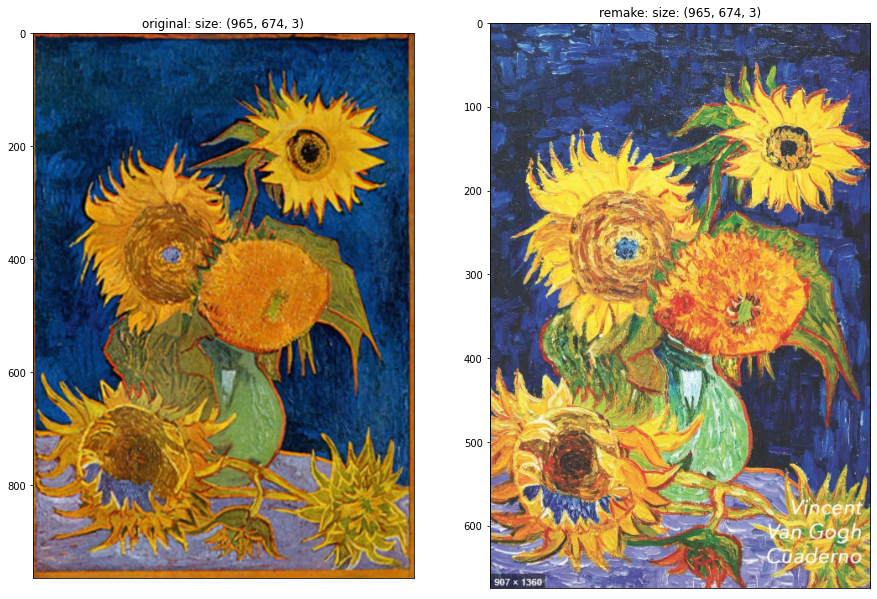

In [0]:
# Load the queries.
img0 = cv2.imread('Images/sunflowers.PNG',)
img1 = cv2.imread('Images/sunflower_remake_letters.PNG')

grey_original = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
grey_remake = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,15))
plt.subplot(121)

plt.subplot(121)
plt.imshow(img0[:,:,::-1])
plt.title('original: size: {}'.format(img0.shape))
plt.xticks([])

plt.subplot(122)
plt.imshow(img1[:,:,::-1])
plt.title('remake: size: {}'.format(img0.shape))
plt.xticks([])

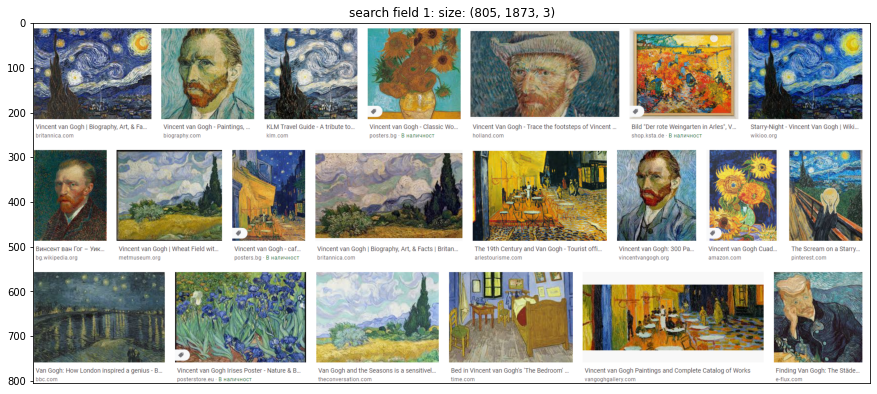

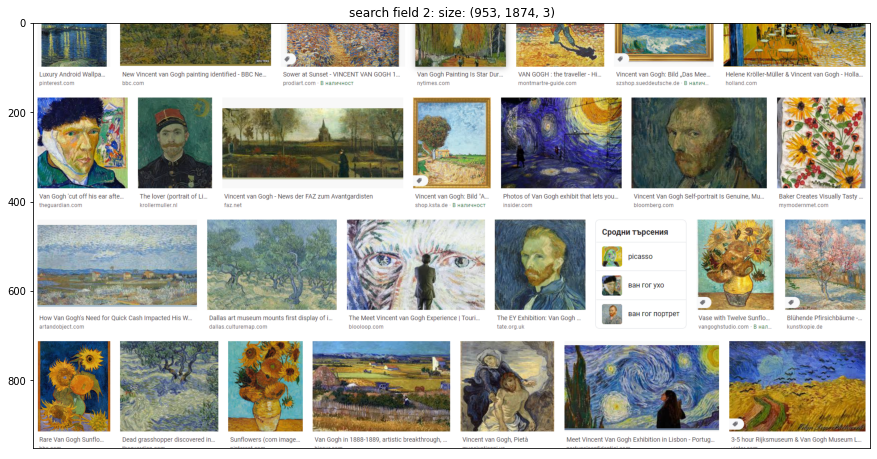

In [0]:
# Load the searchfilds.
img2 = cv2.imread('Images/VanGogh_1.PNG',)
img3 = cv2.imread('Images/VanGogh_2.PNG')

grey_search_1 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
grey_search_2 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,15))
plt.imshow(img2[:,:,::-1])
plt.title('search field 1: size: {}'.format(img2.shape))
plt.xticks([])
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(img3[:,:,::-1])
plt.title('search field 2: size: {}'.format(img3.shape))
plt.xticks([])
plt.show()

## Create Keypoints, Descriptors and Matches

# of identified keypoints: 372


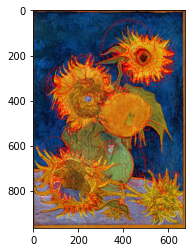

In [0]:
# Get Keypoints and descriptors of each image and search field
# Extracting Keypoints and descriptors with SURF
threshold = 3100 #@param {type:"slider", min:100, max:15000, step:100}
surf = cv2.xfeatures2d.SURF_create(threshold)

kp9, des9 = surf.detectAndCompute(img0, None)

kp0, des0 = surf.detectAndCompute(grey_original, None)
kp1, des1 = surf.detectAndCompute(grey_remake, None)
kp2, des2 = surf.detectAndCompute(grey_search_1, None)
kp3, des3 = surf.detectAndCompute(grey_search_2, None)


img_keypoints = cv2.drawKeypoints(img0, kp0, img0, (0, 0, 255),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print('# of identified keypoints: {}'.format(len(kp0)))
plt.imshow(img_keypoints[:,:,::-1])
plt.show()

In [0]:
# Produce the matches
# Define FLANN-based matching parameters.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Perform FLANN-based matching.
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_1 = flann.knnMatch(des0, des2, k=2)
matches_2 = flann.knnMatch(des0, des3, k=2)
matches_3 = flann.knnMatch(des1, des2, k=2)
matches_4 = flann.knnMatch(des1, des3, k=2)

print(len(matches_1))
print(len(matches_2))
print(len(matches_3))
print(len(matches_4))

# The lenght of the matches depends mainly on the query image obviously

372
372
445
445


In [0]:
# Filter matches based on the ratio test
pair_matches_1 = [x[0] for x in matches_1 if x[0].distance < 0.7* x[1].distance]
print(len(pair_matches_1)) # practical minimum is 10 points

pair_matches_2 = [x[0] for x in matches_2 if x[0].distance < 0.7* x[1].distance]
print(len(pair_matches_2)) # practical minimum is 10 points

pair_matches_3 = [x[0] for x in matches_3 if x[0].distance < 0.7* x[1].distance]
print(len(pair_matches_3)) # practical minimum is 10 points

pair_matches_4 = [x[0] for x in matches_4 if x[0].distance < 0.7* x[1].distance]
print(len(pair_matches_4)) # practical minimum is 10 points

5
23
34
4


Ratio Test Value of 0.7 has been choosen. With thsis it looks for now that qery image 1 apears in search field 2 and image 2 apears in search field 1

# Draw the matches

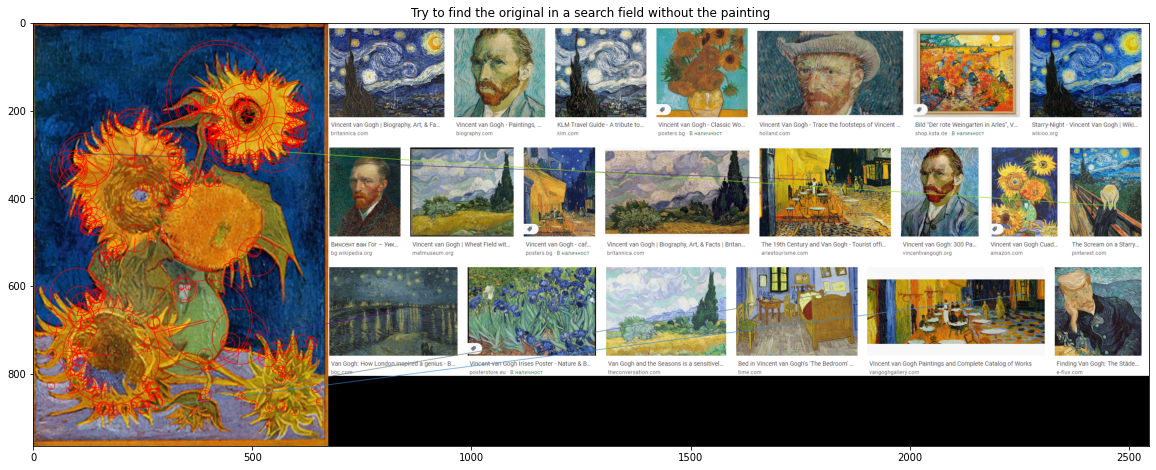

In [0]:
# Draw the best 25 matches.
img_matches = cv2.drawMatches(
    img0, kp0, img2, kp2, pair_matches_1[:], img2,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Show the matches.
plt.figure(figsize=(20,20))
plt.imshow(img_matches[:,:,::-1])
plt.title('Try to find the original in a search field without the painting')
plt.show()

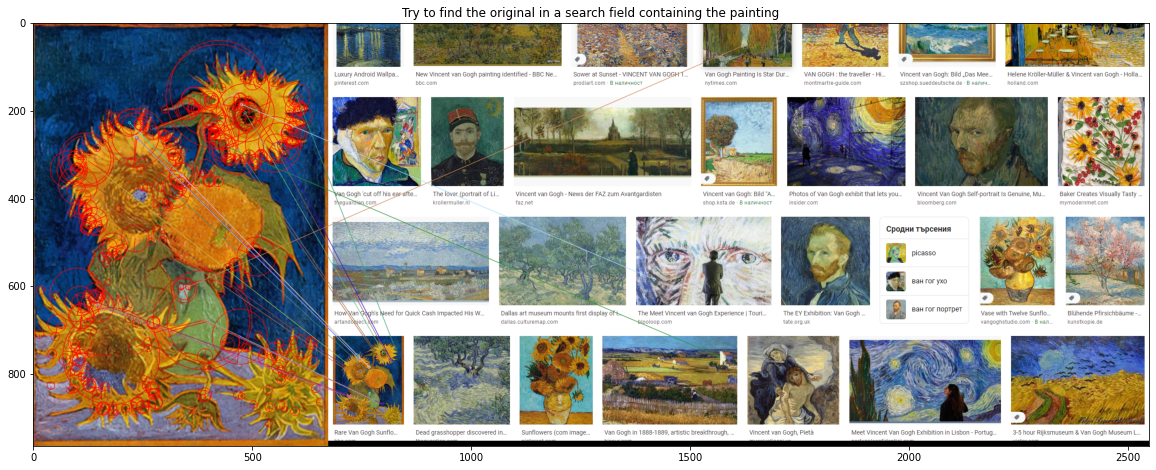

In [0]:
# Draw the matches
img_matches = cv2.drawMatches(
    img0, kp0, img3, kp3, pair_matches_2[:], img3,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Show the matches.
plt.figure(figsize=(20,20))
plt.imshow(img_matches[:,:,::-1])
plt.title('Try to find the original in a search field containing the painting')
plt.show()

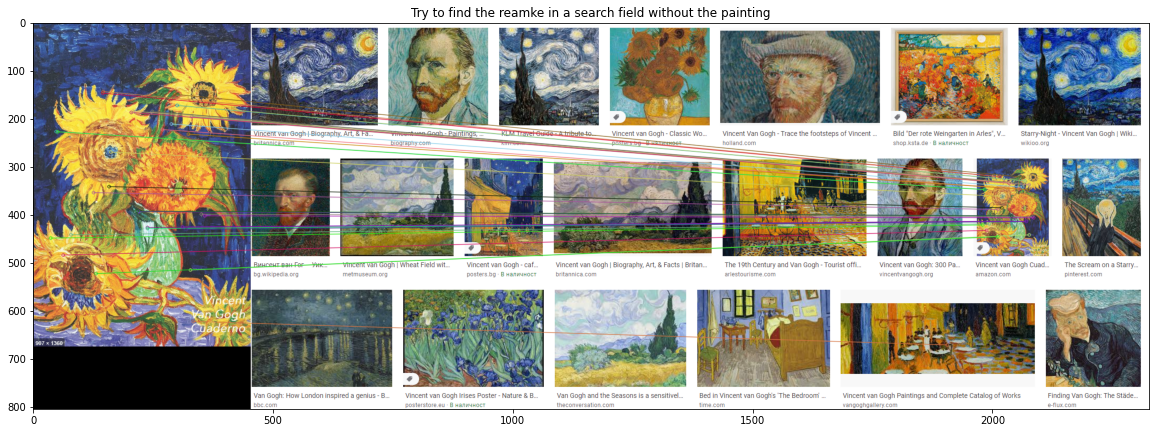

In [0]:
# Draw the matches
img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2, pair_matches_3[:], img2,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Show the matches.
plt.figure(figsize=(20,20))
plt.imshow(img_matches[:,:,::-1])
plt.title('Try to find the reamke in a search field without the painting')
plt.show()

# Querry with manipulated querry image

([], <a list of 0 Text major ticklabel objects>)

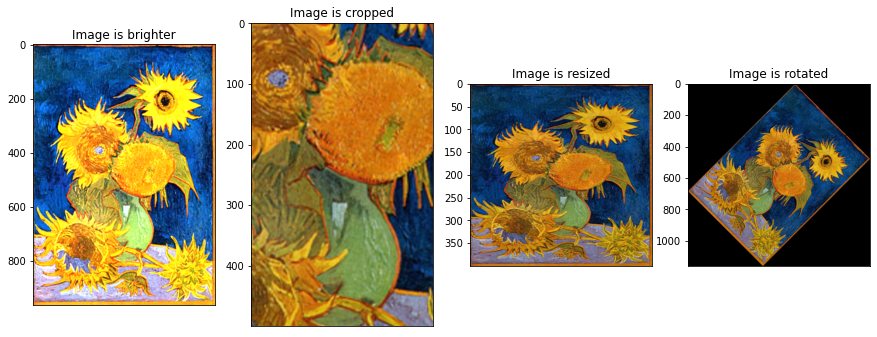

In [0]:
# Image is brither
bright = (cv2.imread('Images/sunflowers.PNG')**1.1).astype(int)
bright = np.clip(bright, 0, 255).astype('uint8')
# bright1 = (cv2.imread('Images/sunflowers.PNG',)**1.1).astype(int)
grey_bright = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
# Image is cropped
crop = cv2.imread('Images/sunflowers.PNG')[300:800, 200:500]
grey_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
# Image is resized
resize = cv2.resize(cv2.imread('Images/sunflowers.PNG'), (400, 400))
grey_resize = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
# Image is rotated
rotate = imutils.rotate_bound(cv2.imread('Images/sunflowers.PNG'), 45)
grey_rotate = cv2.cvtColor(rotate, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(bright[:,:,::-1])
plt.title('Image is brighter')
plt.xticks([])

plt.subplot(142)
plt.imshow(crop[:,:,::-1])
plt.title('Image is cropped')
plt.xticks([])

plt.subplot(143)
plt.imshow(resize[:,:,::-1])
plt.title('Image is resized')
plt.xticks([])

plt.subplot(144)
plt.imshow(rotate[:,:,::-1])
plt.title('Image is rotated')
plt.xticks([])

In [0]:
# Create Keypoints and descriptors
bright_kp, bright_des = surf.detectAndCompute(grey_bright, None)
crop_kp, crop_des = surf.detectAndCompute(grey_crop, None)
resize_kp, resize_des = surf.detectAndCompute(grey_resize, None)
rotate_kp, rotate_des = surf.detectAndCompute(grey_rotate, None)

In [0]:
# Perform FLANN-based matching.
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_bright = flann.knnMatch(bright_des, des3, k=2)
matches_crop = flann.knnMatch(crop_des, des3, k=2)
matches_size = flann.knnMatch(resize_des, des3, k=2)
matches_rotate = flann.knnMatch(rotate_des, des3, k=2)

print(len(matches_bright))
print(len(matches_crop))
print(len(matches_size))
print(len(matches_rotate))

224
53
134
372


In [0]:
# Put the matches through a ratio test
pair_matches_bright = [x[0] for x in matches_bright if x[0].distance < 0.7* x[1].distance]
print(len(pair_matches_bright)) # practical minimum is 10 points

pair_matches_crop = [x[0] for x in matches_crop if x[0].distance < 0.7* x[1].distance]
print(len(pair_matches_crop)) # practical minimum is 10 points

pair_matches_size = [x[0] for x in matches_size if x[0].distance < 0.7* x[1].distance]
print(len(pair_matches_size)) # practical minimum is 10 points

pair_matches_rotate = [x[0] for x in matches_rotate if x[0].distance < 0.7* x[1].distance]
print(len(pair_matches_rotate)) # practical minimum is 10 points

7
3
9
14


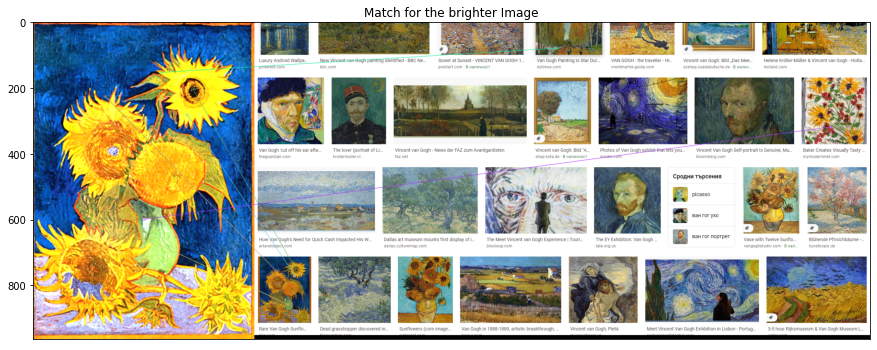

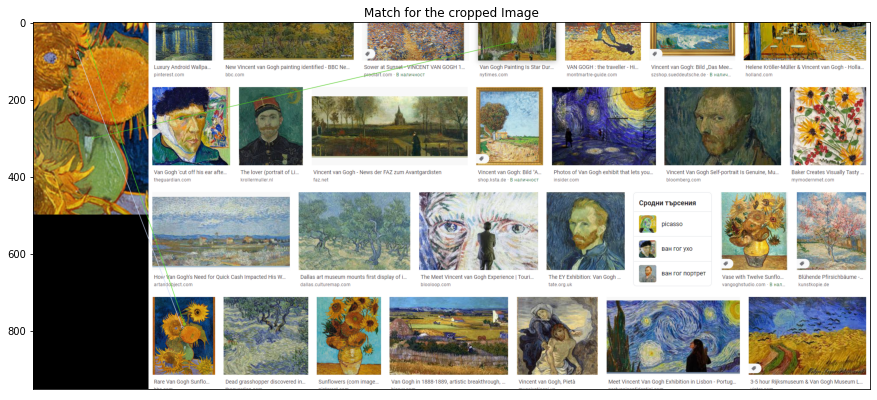

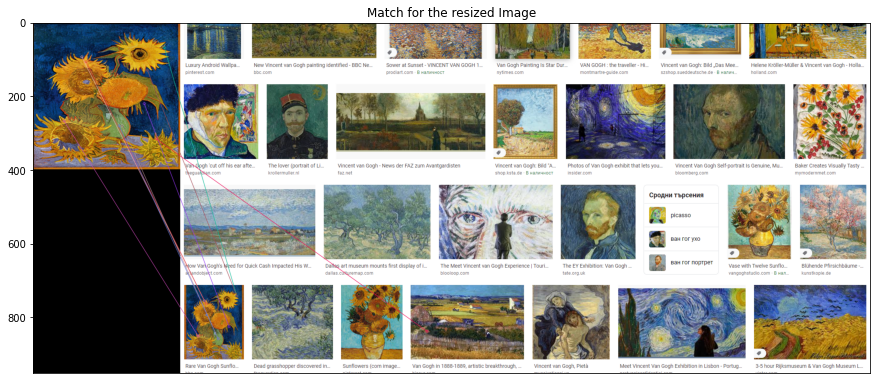

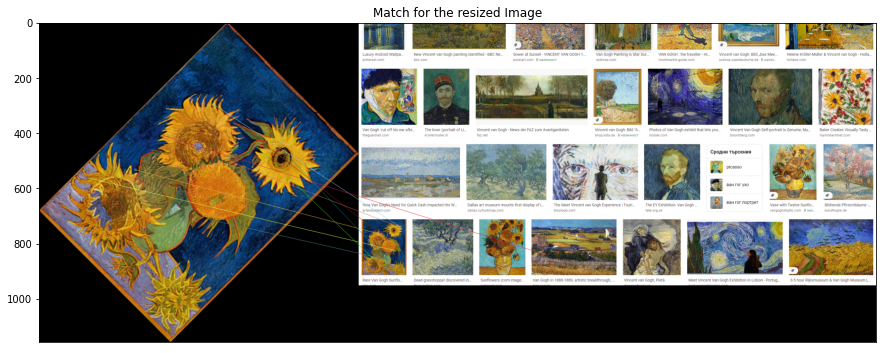

In [0]:
# Draw the matches
img_matches_bright = cv2.drawMatches(
    bright, bright_kp, img3, kp3, pair_matches_bright[:], img3,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

img_matches_crop = cv2.drawMatches(
    crop, crop_kp, img3, kp3, pair_matches_crop[:], img3,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

img_matches_size = cv2.drawMatches(
    resize, resize_kp, img3, kp3, pair_matches_size[:], img3,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

img_matches_rotate = cv2.drawMatches(
    rotate, rotate_kp, img3, kp3, pair_matches_size[:], img3,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Show the results
plt.figure(figsize=(15,15))
plt.imshow(img_matches_bright[:,:,::-1])
plt.title('Match for the brighter Image')
plt.xticks([])
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(img_matches_crop[:,:,::-1])
plt.title('Match for the cropped Image')
plt.xticks([])
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(img_matches_size[:,:,::-1])
plt.title('Match for the resized Image')
plt.xticks([])
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(img_matches_rotate[:,:,::-1])
plt.title('Match for the resized Image')
plt.xticks([])
plt.show()